In [53]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import logging
import sys
import data_processing
import visualisation
import inference

from model import UNet

# configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[
        logging.StreamHandler(sys.stdout)
    ]
)
logger = logging.getLogger()
logger.setLevel(logging.INFO)

device = 'cpu'
sample = 1552
samples = {
    1552: {
        "axial_projection": 61,
        "sagittal_projection": 139,
        "coronal_projection": 78,
    },
    138: {
        "axial_projection": 52,
        "sagittal_projection": 75,
        "coronal_projection": 164,
    }
}

In [54]:
# Data loading
from brats_dataset import BratsDataset

brats = BratsDataset(
    "/Users/sw/work/msc_ai_diss/BraTS/RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021")
mri, target = brats.load_sample(sample)
logging.info(f"mri shape: {mri.shape}")
logging.info(f"segmentation shape: {target.shape}")

dataset = mri[np.newaxis, ...]  # Adding "batch" dimension
dataset = torch.as_tensor(dataset, device=device, dtype=torch.float)
logging.info(f"dataset shape: {dataset.shape}")


2023-09-22 22:53:07,594 [INFO] Loaded image: /Users/sw/work/msc_ai_diss/BraTS/RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021/BraTS2021_01552/BraTS2021_01552_flair.nii.gz (took 0.1s)
2023-09-22 22:53:07,700 [INFO] Loaded image: /Users/sw/work/msc_ai_diss/BraTS/RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021/BraTS2021_01552/BraTS2021_01552_t1.nii.gz (took 0.1s)
2023-09-22 22:53:07,798 [INFO] Loaded image: /Users/sw/work/msc_ai_diss/BraTS/RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021/BraTS2021_01552/BraTS2021_01552_t1ce.nii.gz (took 0.1s)
2023-09-22 22:53:07,896 [INFO] Loaded image: /Users/sw/work/msc_ai_diss/BraTS/RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021/BraTS2021_01552/BraTS2021_01552_t2.nii.gz (took 0.1s)
2023-09-22 22:53:07,956 [INFO] MRI image shape: (4, 240, 240, 144)
2023-09-22 22:53:07,975 [INFO] Loaded image: /Users/sw/work/msc_ai_diss/BraTS/RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021/BraTS2021_01552/BraTS2021_01552_seg.nii.gz (took 0.0s)
2023-09-22 2

Metadata: {'arguments': "['/root/Segmentation/main.py', '--brats_dir=/root/data/BraTS_100', '--output_dir=/root/output', '--brats_validation_dir=/root/data/BraTS_10', '--epochs=1000', '--use_cache=True', '--epochs_per_checkpoint=5', '--epochs_per_permanent_checkpoint=50', '--learning_rate=0.01', '--batch_size=2']", 'result_path': '/root/output/2023_08_29__21_48_13'}


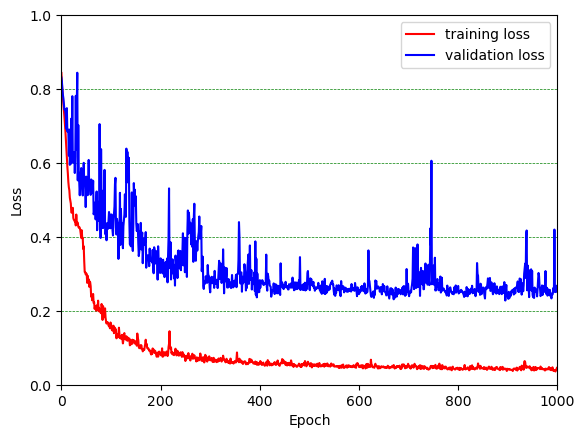

train loss:  0.04233886756896973
val loss:  0.2583029005527496


In [52]:
# Load model, plot learning curves

# good results, 1000 epochs
# checkpoint_path = "/Users/sw/msc_ai_diss/output/2023_07_01__15_09_46__n_30/checkpoint.pth"

# nitt
# checkpoint_path = "/Users/sw/msc_ai_diss/output/nitt/2023_08_27__22_54_00/checkpoint_epoch80.pth"

# vast
checkpoint_path = "/Users/sw/msc_ai_diss/output/_vast/2023_08_29__21_48_13/checkpoint_epoch1000.pth"

checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

print(f"Metadata: {checkpoint['description']}")

losses = checkpoint['losses']
epoch = checkpoint['epoch']
num_epochs = checkpoint['num_epochs']
val_losses = checkpoint['val_losses']

x = np.arange(len(losses))
y = losses
y2 = val_losses

# plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xlim([0, num_epochs])

plt.ylim([0., 1.])
plt.grid(axis='y', color='green', linestyle='--', linewidth=0.5)
plt.plot(x, y, color="red", label="training loss")
plt.plot(x, y2, color="blue", label="validation loss")
plt.legend(loc="upper right")
plt.show()

print("train loss: ", np.mean(losses[950:]))
print("val loss: ", np.mean(val_losses[950:]))

In [5]:
# Inference

inf = inference.Inference(checkpoint_path, device=device)
pred = inf.predict(dataset)


2023-09-14 01:00:34,470 [INFO] Loading model from [/Users/sw/msc_ai_diss/output/_vast/2023_08_29__21_48_13/checkpoint_epoch1000.pth]
2023-09-14 01:00:34,586 [INFO] Running inference...
2023-09-14 01:02:47,583 [INFO] Prediction shape: torch.Size([1, 4, 240, 240, 144]) (prediction took: 133.0s)


(4, 240, 240, 144)
(4, 240, 240, 155)
2023-09-22 22:53:15,062 [INFO] prediction_4d shape: torch.Size([4, 240, 240, 144])
2023-09-22 22:53:15,777 [INFO] prediction_4d shape: torch.Size([4, 240, 240, 155])
2023-09-22 22:53:17,182 [INFO] Prediction shape: torch.Size([240, 240, 155])
(240, 240, 155)
{'axial_projection': 61, 'sagittal_projection': 139, 'coronal_projection': 78}
MRI shape: (4, 240, 240, 155)
segmentation shape: N/A
MRI shape: (4, 240, 240, 155)
segmentation shape: (240, 240, 155)
MRI shape: (4, 240, 240, 155)
segmentation shape: torch.Size([240, 240, 155])


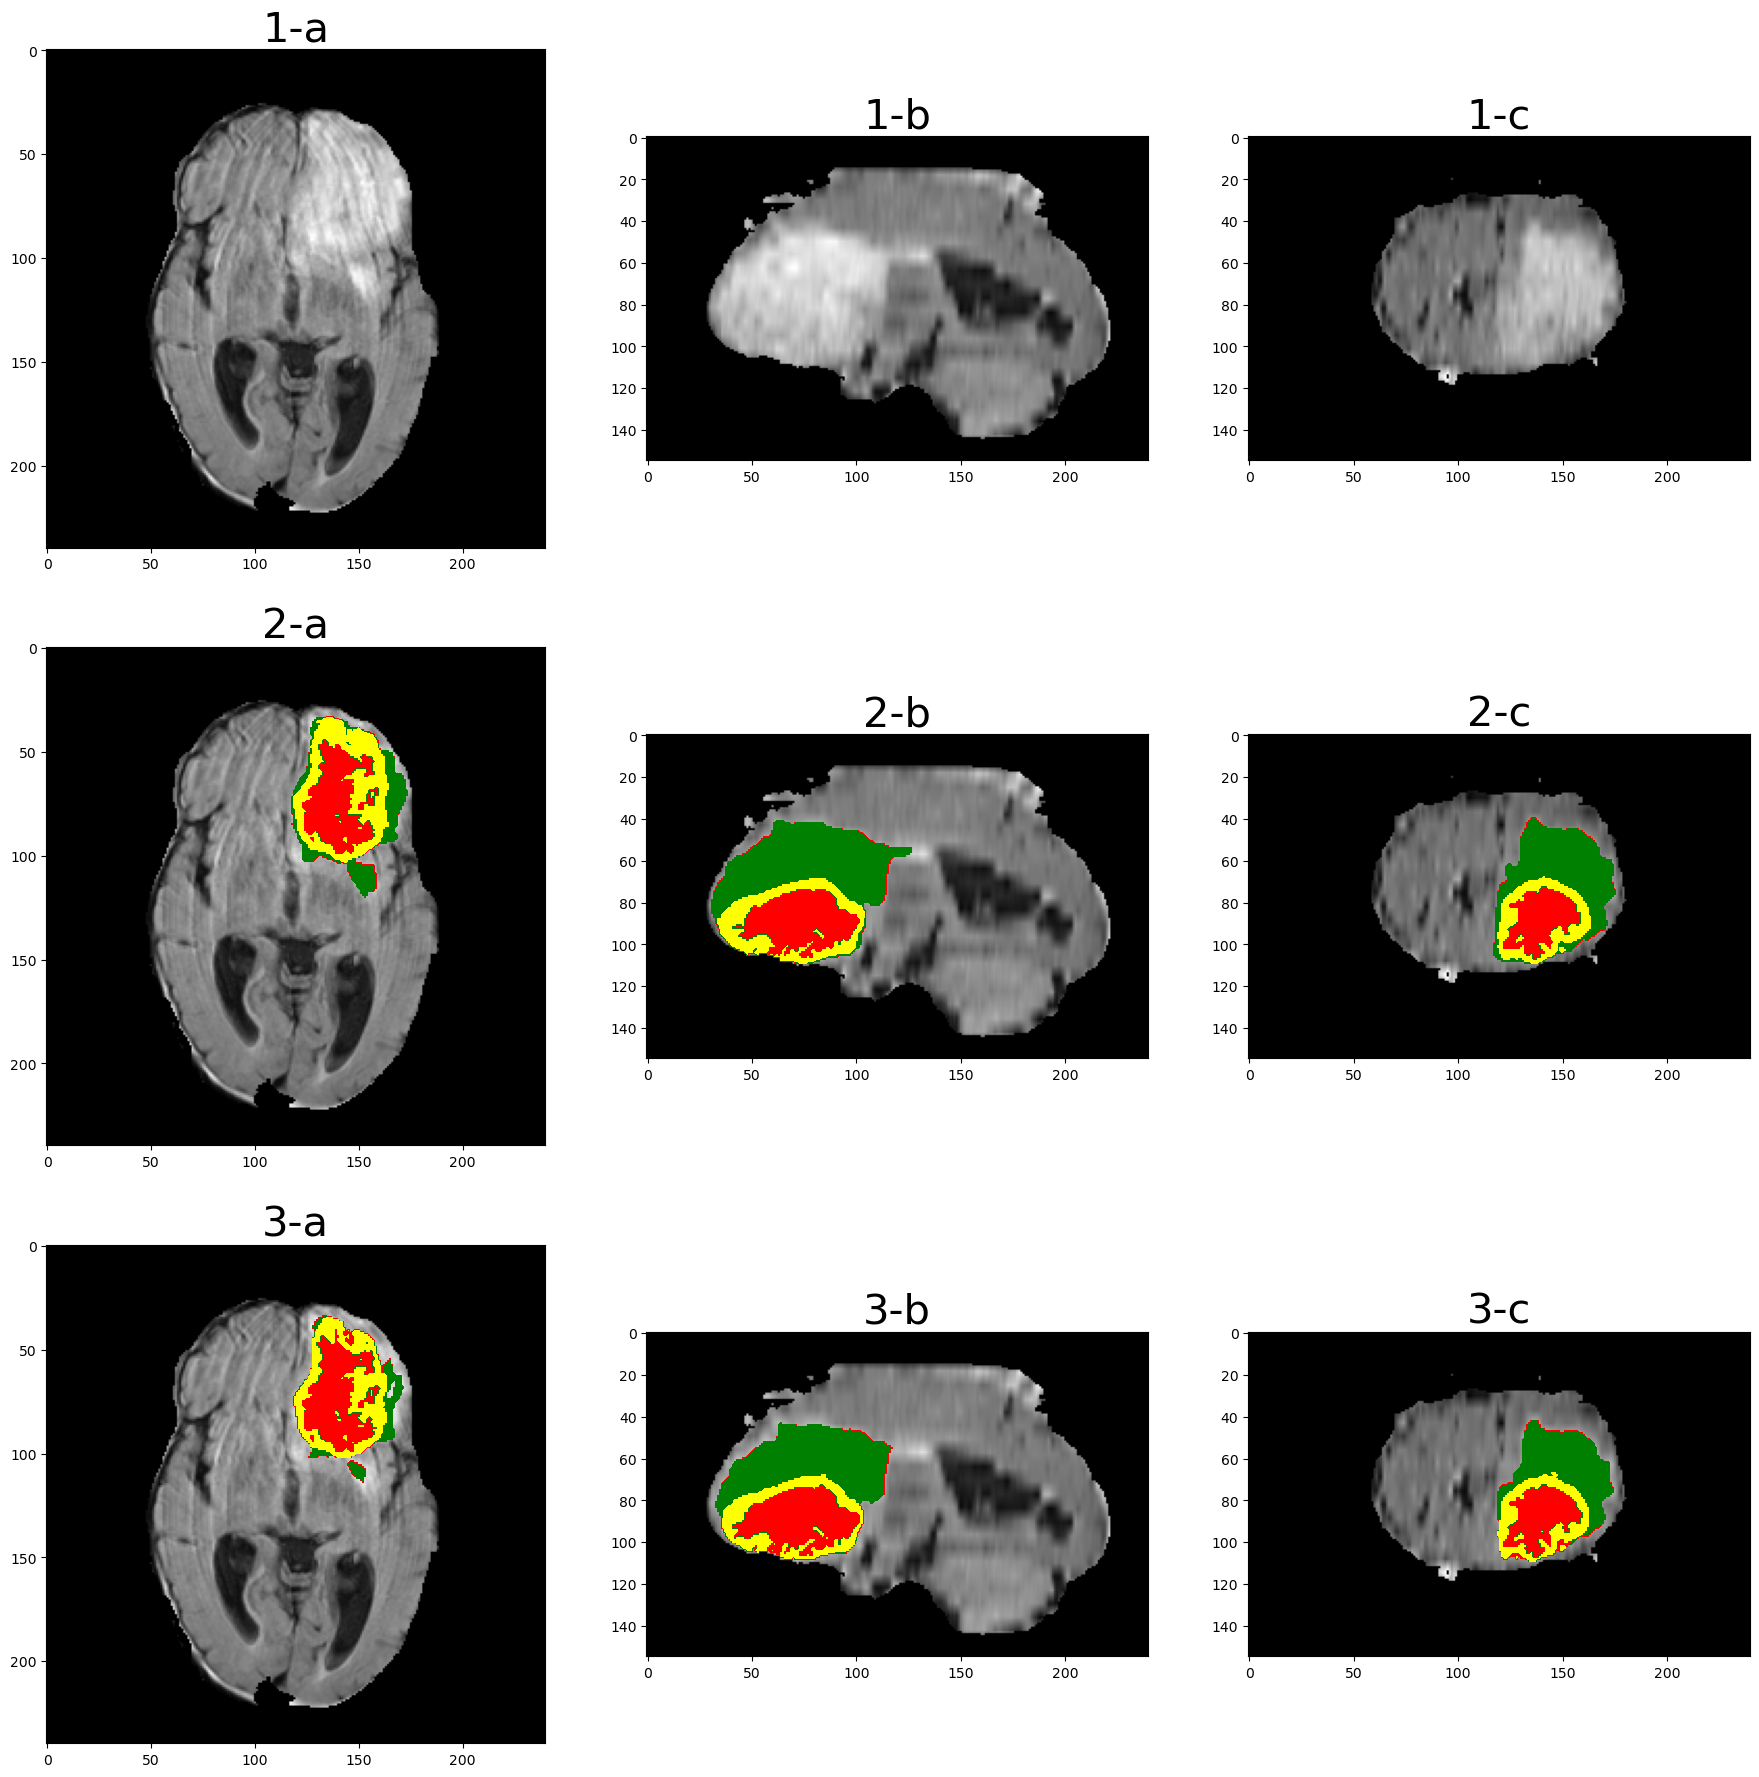

In [55]:
# Visualisation

import brats_dataset

import importlib

importlib.reload(brats_dataset)
importlib.reload(visualisation)

import brats_dataset
from brats_dataset import BratsDataset


def flip_vertically(image):
    return torch.flip(torch.as_tensor(image), dims=[0])
    # return np.flip(image, axis=0)


# MRI
print(mri.shape)
mri_unclipped = brats_dataset.unclip_4d(mri)
print(mri_unclipped.shape)

# result (prediction)
result_unclipped = data_processing.segmentation_3d_from_prediction_4d(pred[0], unclip=True)

# target
# target_unclipped = torch.as_tensor(target, dtype=torch.int)
target_unclipped = brats_dataset.unclip_4d(target)
target_unclipped = target_unclipped[0]
print(target_unclipped.shape)

torch.set_printoptions(threshold=100_000, linewidth=1000)
#torch.set_printoptions(profile="default")

#plt.grid(False)

columns = 3
rows = 3
fig = plt.figure(figsize=(22, 22))


class FigNumProvider:
    fig_num = 0

    def next_fig_num(self):
        self.fig_num += 1
        return self.fig_num


fig_num_provider = FigNumProvider()

modality = 0


def show_segmentation(segmentation, axial_projection, sagittal_projection, coronal_projection,
                      row_title):
    print(f"MRI shape: {mri_unclipped.shape}")
    print(f"segmentation shape: {segmentation.shape if segmentation is not None else 'N/A'}")
    ax = fig.add_subplot(rows, columns, fig_num_provider.next_fig_num())
    ax.set_title(f"{row_title}-a", fontsize=30)
    plt.imshow(mri[modality, :, :, axial_projection].T, cmap='gray')
    if segmentation is not None:
        plt.imshow(segmentation[:, :, axial_projection].T, cmap=visualisation.segmentation_cmap)

    ax = fig.add_subplot(rows, columns, fig_num_provider.next_fig_num())
    ax.set_title(f"{row_title}-b", fontsize=30)
    plt.imshow(flip_vertically(mri_unclipped[modality, sagittal_projection, :, :].T), cmap='gray')
    if segmentation is not None:
        plt.imshow(flip_vertically(segmentation[sagittal_projection, :, :].T),
                   cmap=visualisation.segmentation_cmap)

    ax = fig.add_subplot(rows, columns, fig_num_provider.next_fig_num(), title=f"{row_title}-c")
    ax.set_title(f"{row_title}-c", fontsize=30)
    plt.imshow(flip_vertically(mri_unclipped[modality, :, coronal_projection, :].T), cmap='gray')
    if segmentation is not None:
        plt.imshow(flip_vertically(segmentation[:, coronal_projection, :].T),
                   cmap=visualisation.segmentation_cmap)


projections = samples[sample]
print(projections)

show_segmentation(None, **projections, row_title=1)
show_segmentation(target_unclipped, **projections, row_title=2)
show_segmentation(result_unclipped, **projections, row_title=3)

#fig.tight_layout()
plt.show()



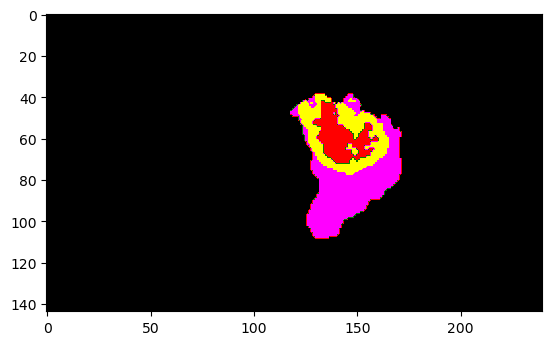

In [91]:
segm_cmap = colors.ListedColormap(['black', 'red', 'green', 'magenta', 'yellow'])
plt.imshow(target[:, :, 61].T, cmap=segm_cmap)
plt.grid(False)

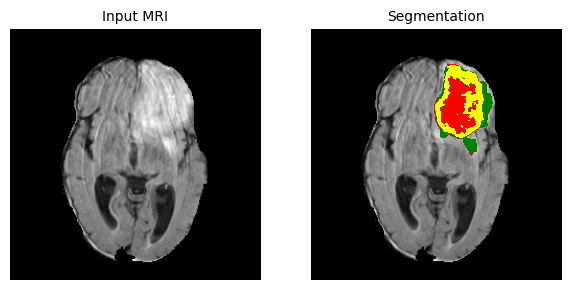

In [60]:
# Segmentation example

columns = 3
rows = 1
fig = plt.figure(figsize=(11, 22))

axial_projection = 61

segmentation = target_unclipped

chart_num = 1

ax = fig.add_subplot(rows, columns, chart_num)
chart_num += 1
ax.set_title("Input MRI", fontsize=10)
ax.set_axis_off()
plt.imshow(mri[modality, :, :, axial_projection].T, cmap='gray')

ax = fig.add_subplot(rows, columns, chart_num)
chart_num += 1
ax.set_title("Segmentation", fontsize=10)
ax.set_axis_off()
plt.imshow(mri[modality, :, :, axial_projection].T, cmap='gray')
plt.imshow(segmentation[:, :, axial_projection].T, cmap=visualisation.segmentation_cmap)
